In [75]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [76]:
df=pd.read_excel("../resources/premiums_rest.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [77]:
df["genetical_risk"]=0

In [78]:
df.shape

(29904, 14)

In [79]:
df.columns = df.columns.str.replace(" ",'_').str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


### Handling Null Values

In [80]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [81]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

### Check duplicate Values

In [82]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

### Check Outliers

In [83]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.379910,23.364184,20892.303821,0.0
std,13.412657,1.431201,24.740339,6936.813440,0.0
min,26.000000,-3.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


In [84]:
df[df.number_of_dependants < 0]["number_of_dependants"].unique()

array([-1, -3])

In [85]:
df["number_of_dependants"] = abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [86]:
numeric_columns=df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

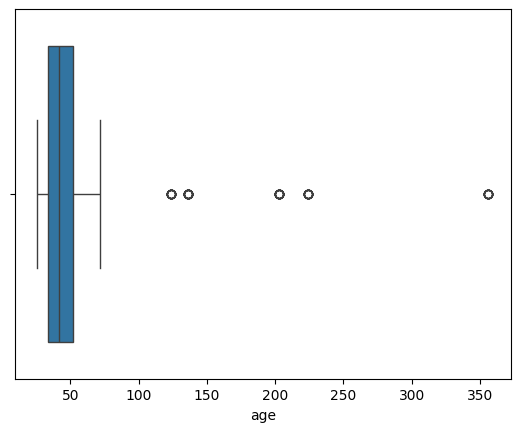

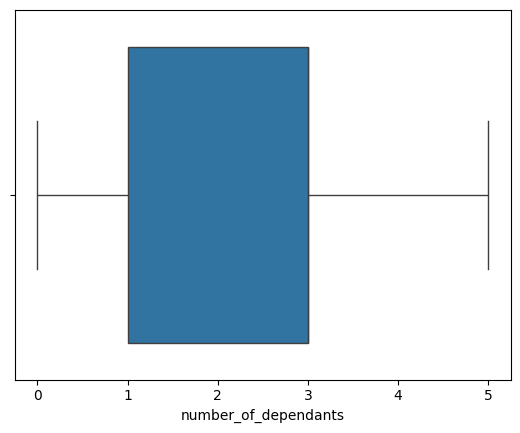

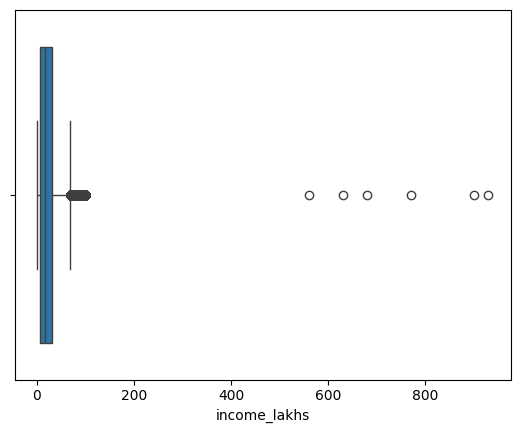

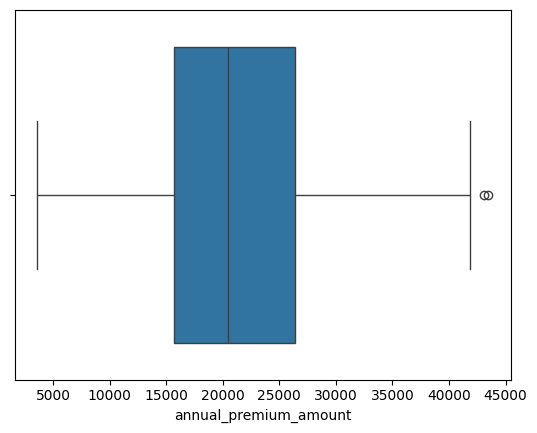

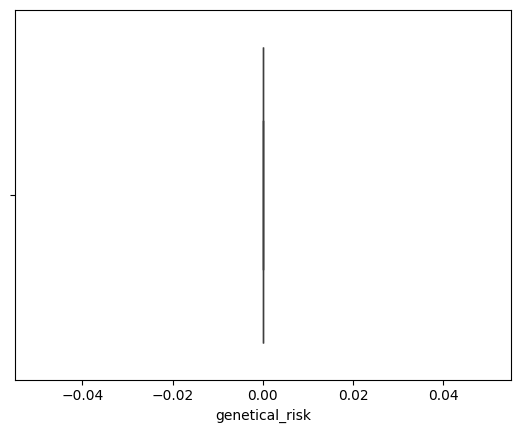

In [87]:
for column in numeric_columns:
    sns.boxplot(x=df[column])
    plt.show()

In [88]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [89]:
df1=df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29828.000000,29828.000000,29828.000000,29828.000000,29828.0
mean,43.095380,2.387790,23.371530,20901.900563,0.0
std,11.041991,1.420641,24.751262,6928.457636,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15706.000000,0.0
50%,42.000000,3.000000,17.000000,20496.000000,0.0
75%,52.000000,3.000000,32.000000,26361.000000,0.0
max,72.000000,5.000000,930.000000,43471.000000,0.0


In [90]:
def get_iqr_bounds(col):
    Q1, Q3=col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound,upper_bound 


In [91]:
get_iqr_bounds(df1.income_lakhs)

(-30.5, 69.5)

In [92]:
quantile_treshold=df1.income_lakhs.quantile(0.999)

In [93]:
df2=df1[df1.income_lakhs <= quantile_treshold].copy()

In [94]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.0
mean,43.094896,2.387734,23.226343,20900.689223,0.0
std,11.042430,1.420644,22.455408,6928.192115,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15705.250000,0.0
50%,42.000000,3.000000,17.000000,20495.500000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,72.000000,5.000000,100.000000,43471.000000,0.0


### Distribution of Dataset

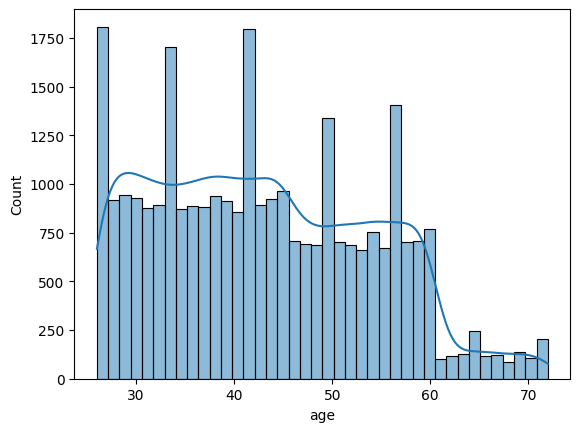

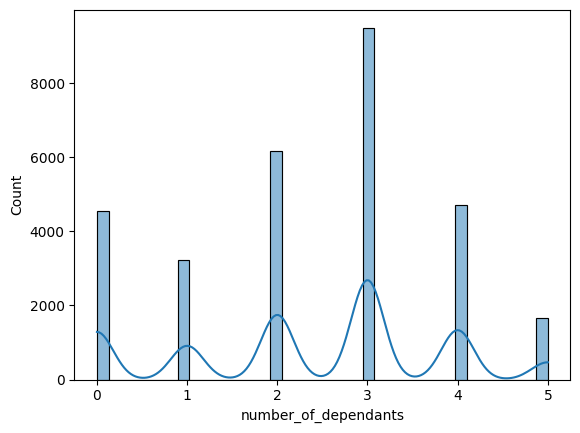

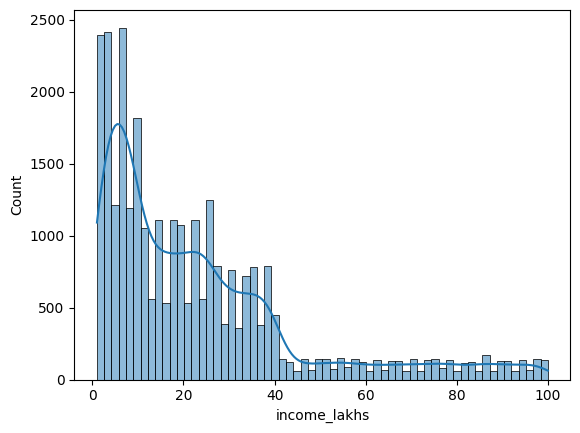

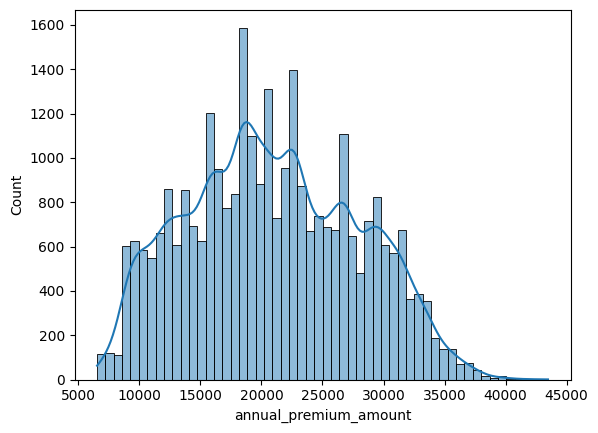

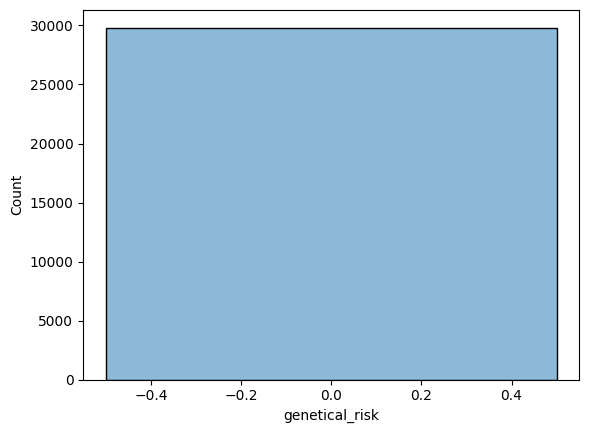

In [95]:
for col in numeric_columns:
    sns.histplot(df2[col],kde=True)
    plt.show()

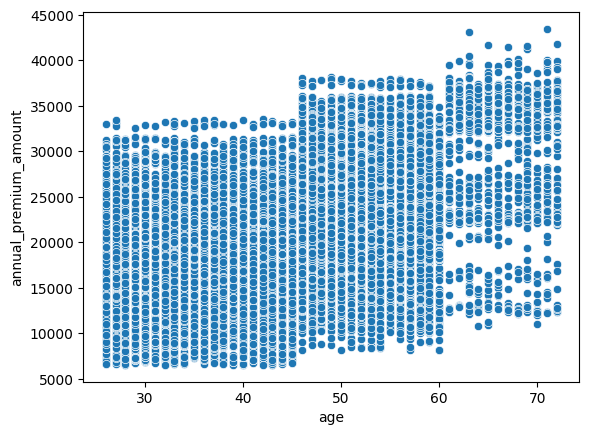

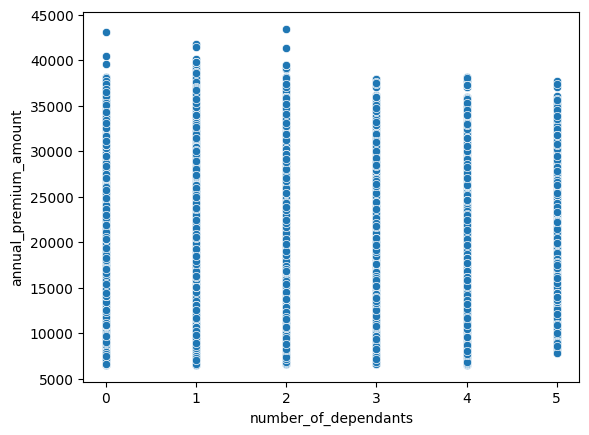

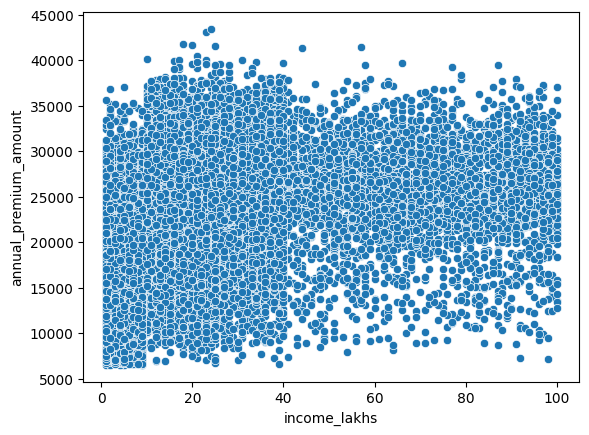

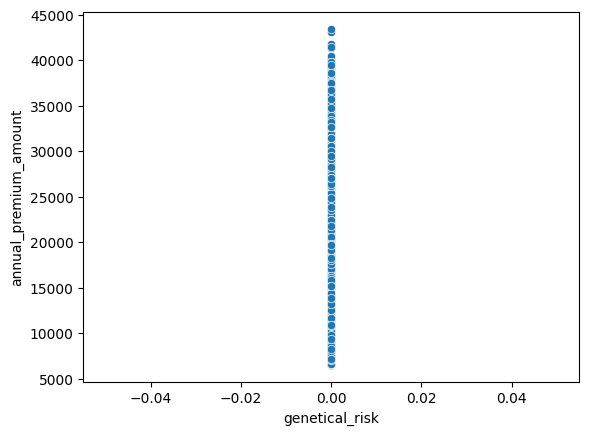

In [96]:
for col in numeric_columns:
    if col != "annual_premium_amount":
        sns.scatterplot(df2,x=col,y="annual_premium_amount")
        plt.show()

In [97]:
categorical_cols=list(set(df2.columns)-set(numeric_columns))
for col in categorical_cols:
    print(col,":",df2[col].unique())

income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
insurance_plan : ['Bronze' 'Silver' 'Gold']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
gender : ['Male' 'Female']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
marital_status : ['Unmarried' 'Married']


In [98]:
df2["smoking_status"].replace({
    "Does Not Smoke":"No Smoking",
    "Smoking=0":"No Smoking",
    "Not Smoking":"No Smoking"
},inplace=True)

/tmp/ipykernel_29144/72047604.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["smoking_status"].replace({


In [99]:
pct_count=df2["gender"].value_counts(normalize=True)
pct_count

gender
Male      0.549125
Female    0.450875
Name: proportion, dtype: float64

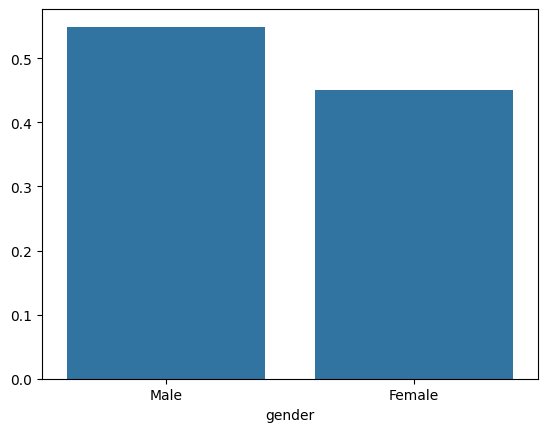

In [100]:
sns.barplot(x=pct_count.index,y=pct_count.values)
plt.show()

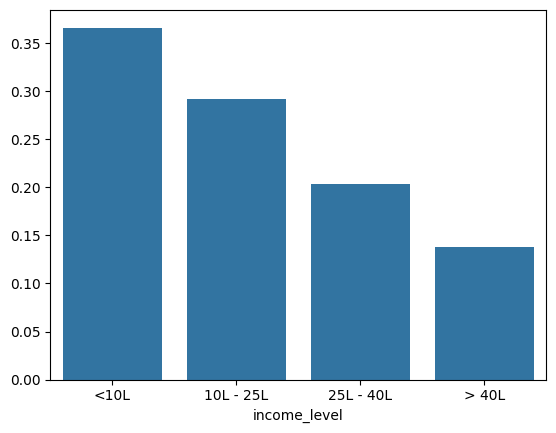

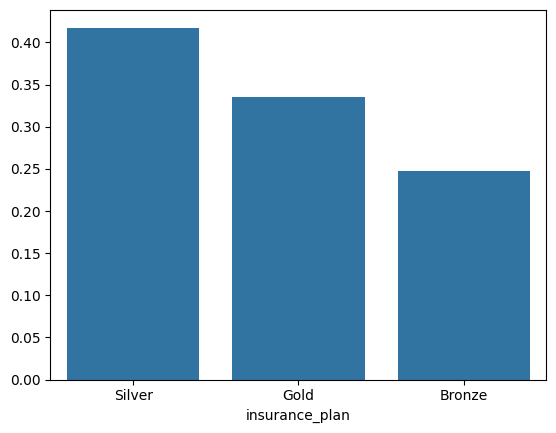

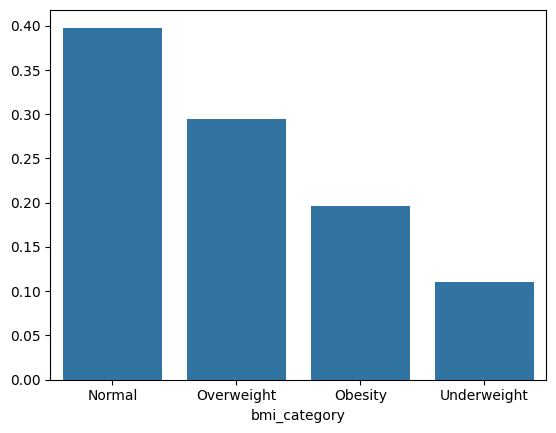

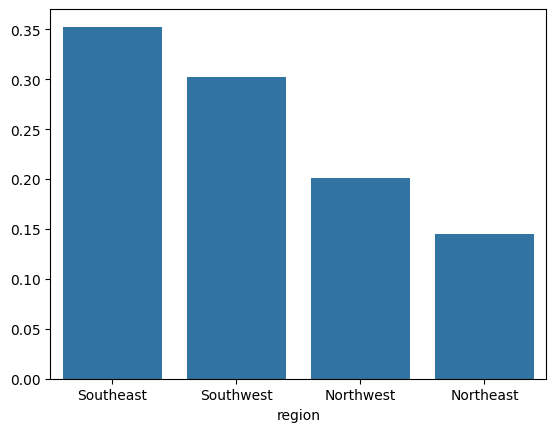

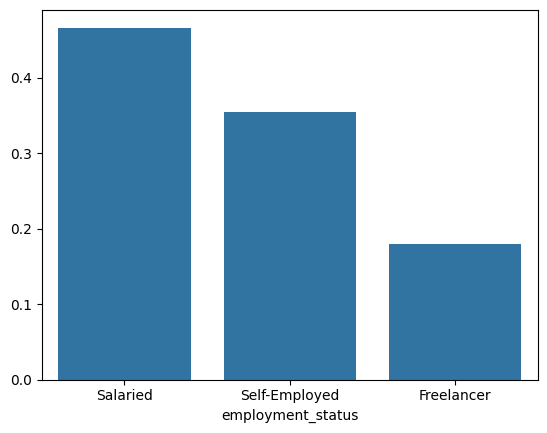

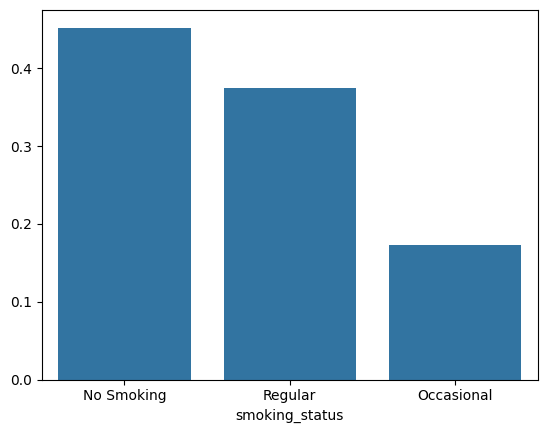

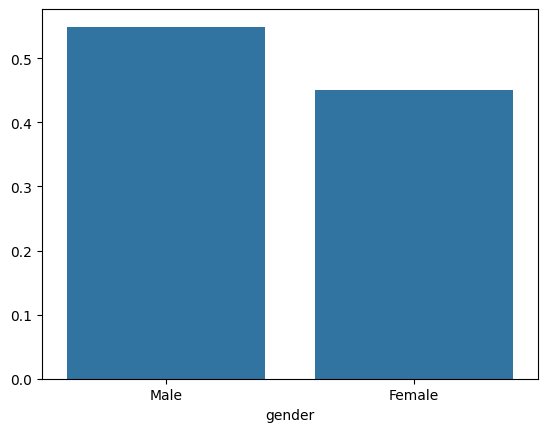

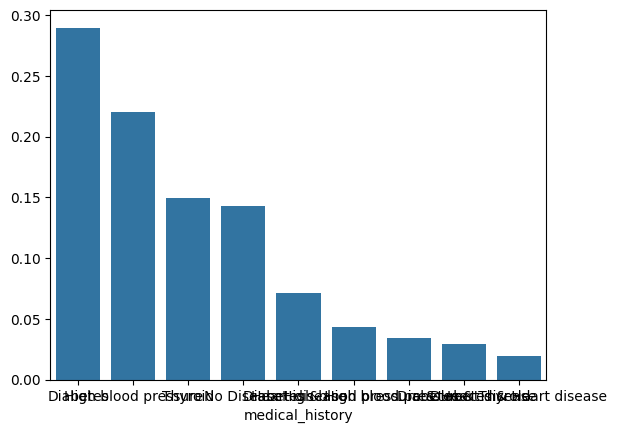

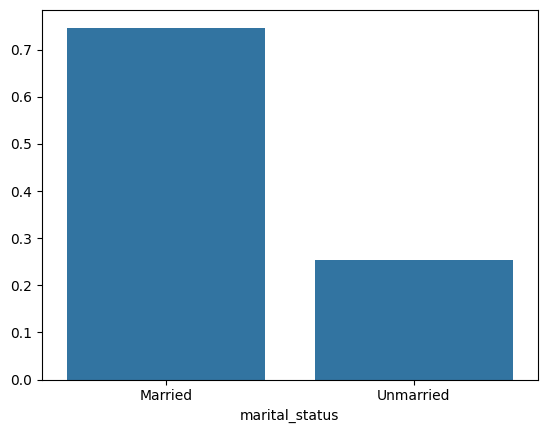

In [101]:
for col in categorical_cols:
    pct_count=df2[col].value_counts(normalize=True)
    sns.barplot(x=pct_count.index,y=pct_count.values)
    plt.show()

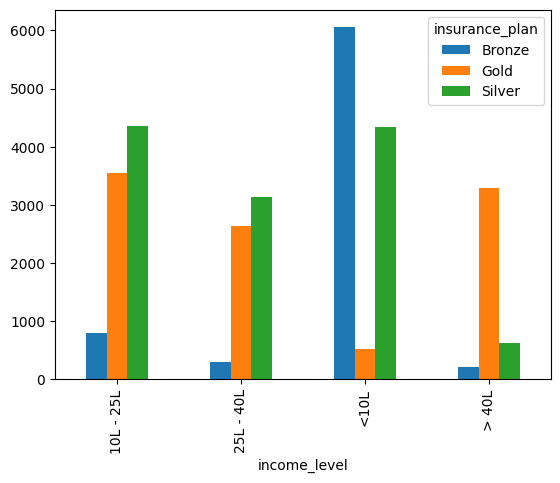

In [102]:
crosstab=pd.crosstab(df2["income_level"],df2["insurance_plan"])
crosstab.plot(kind="bar")
plt.show()

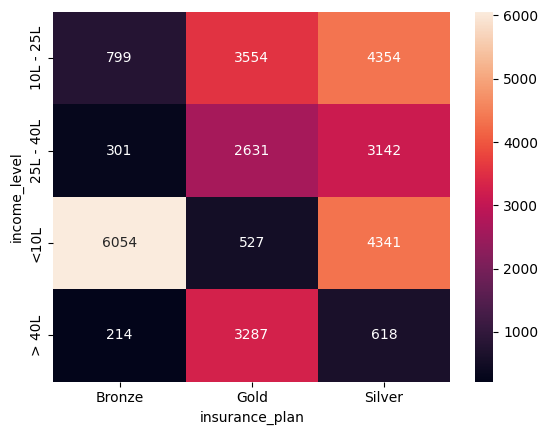

In [103]:
sns.heatmap(crosstab,annot=True,fmt="d")
plt.show()

In [104]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0


In [105]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [106]:
risk_scores={
    "Diabetes":6,
    "Heart disease":8,
    "High blood pressure":6,
    "Thyroid":5,
    "No Disease":0,
    "None":0
}
df2[["disease1","disease2"]]=df2["medical_history"].str.split(" & ",expand=True).apply(lambda x: x.str.lower())
df2.head(10)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0,no disease,None
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0,diabetes,None
5,33,Male,Southeast,Married,3,Normal,Regular,Self-Employed,<10L,4,Diabetes & High blood pressure,Silver,20653,0,diabetes,high blood pressure
6,43,Male,Northeast,Married,3,Overweight,Regular,Salaried,> 40L,46,Thyroid,Gold,26926,0,thyroid,None
7,59,Female,Southeast,Unmarried,0,Overweight,No Smoking,Freelancer,10L - 25L,21,No Disease,Gold,26101,0,no disease,None
8,46,Female,Southeast,Married,4,Normal,Occasional,Self-Employed,10L - 25L,21,Thyroid,Gold,27176,0,thyroid,None
9,68,Female,Southwest,Married,1,Normal,No Smoking,Self-Employed,<10L,1,Diabetes,Bronze,12596,0,diabetes,None


In [107]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

/tmp/ipykernel_29144/59644619.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
/tmp/ipykernel_29144/59644619.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,none,6,0.428571


In [108]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [109]:
df2['insurance_plan']=df2['insurance_plan'].map({"Bronze":1,"Silver":2,"Gold":3})

In [110]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [111]:
df2['income_level']=df2['income_level'].map({"<10L":1,"10L - 25L":2,"> 40L":3,"25L - 40L":4})

In [112]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,0,diabetes,none,6,0.428571


In [113]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,0,diabetes,none,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,0,diabetes,none,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,0,high blood pressure,none,...,0,0,0,0,0,0,0,0,0,1


In [114]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


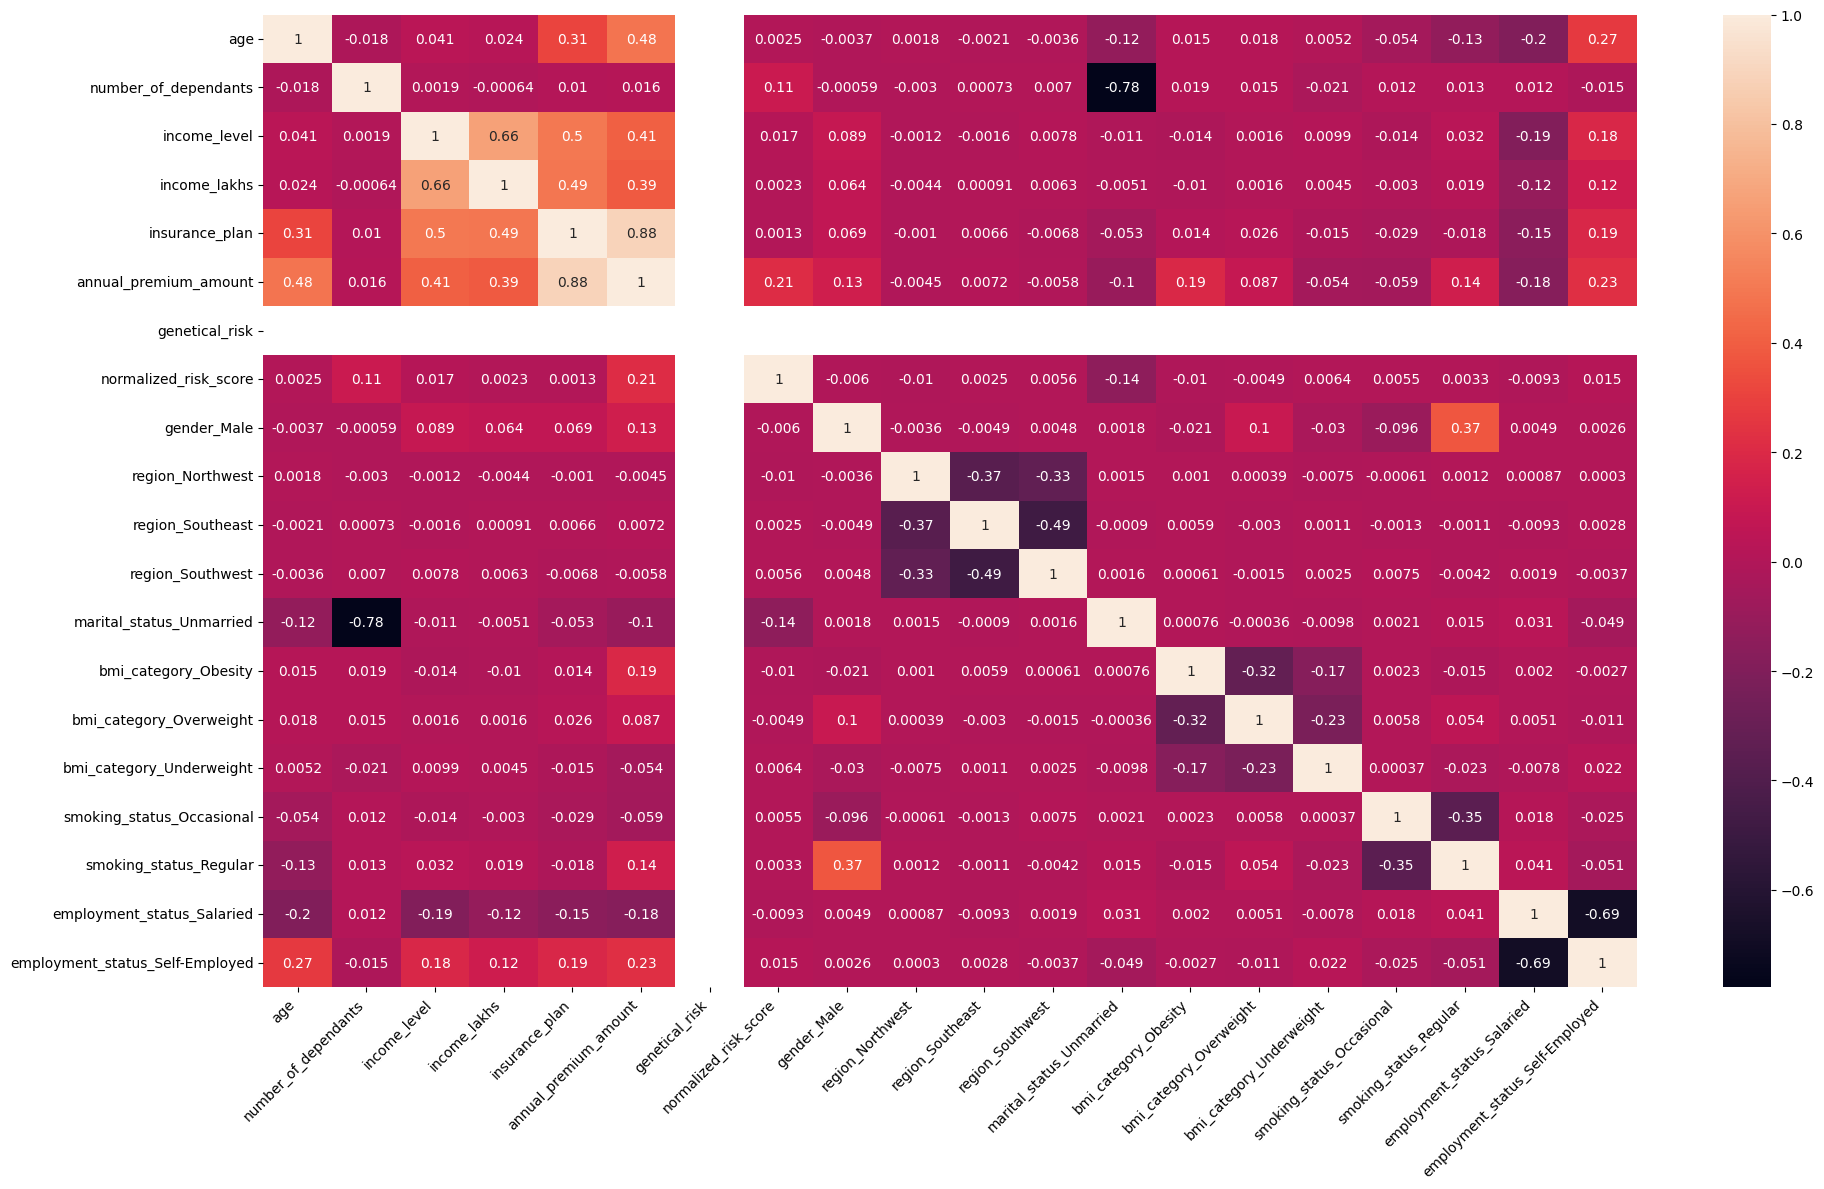

In [115]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [116]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


In [117]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan','genetical_risk']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.0,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.393077,0.224509,0.544112,0.0,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.378150,0.226822,0.379009,0.0,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.0,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.0,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.0,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [118]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [119]:
calculate_vif(X)

/home/xamon/Documenti/health_care_premium/.venv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.882319
1,number_of_dependants,6.292550
2,income_level,4.104266
3,income_lakhs,3.797992
4,insurance_plan,4.931114
5,genetical_risk,NaN
6,normalized_risk_score,3.815157
7,gender_Male,2.599039
8,region_Northwest,2.124859
9,region_Southeast,2.981854


In [120]:
calculate_vif(X.drop('income_level', axis="columns"))

/home/xamon/Documenti/health_care_premium/.venv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,genetical_risk,NaN
5,normalized_risk_score,3.808345
6,gender_Male,2.591439
7,region_Northwest,2.123277
8,region_Southeast,2.979899
9,region_Southwest,2.708641


In [121]:
# we will drop income_lakhs due to high VIF value
X_reduced = X.drop('income_level', axis="columns")

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
X_train,X_test,y_train,y_test=train_test_split(X_reduced,y,test_size=0.3)

In [124]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
train_score= model_lr.score(X_train,y_train)
test_score= model_lr.score(X_test,y_test)
train_score,test_score

(0.9535251798868327, 0.953595276348297)

In [125]:
model_lr.intercept_

np.float64(5903.55777409105)

In [126]:
model_lr.coef_

array([ 6999.995247, -1282.768552,  -747.990959, 14838.260463,
          -0.      ,  6034.528817,    62.771761,     1.423369,
          42.989446,    47.29847 ,  -698.471585,  3922.212494,
        1971.760742,   602.634607,   818.215219,  2766.228812,
         -67.091856,   226.340431])

In [127]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  2224474.169719779 RMSE:  1491.467119892282


In [128]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([ 6999.995247, -1282.768552,  -747.990959, 14838.260463,
          -0.      ,  6034.528817,    62.771761,     1.423369,
          42.989446,    47.29847 ,  -698.471585,  3922.212494,
        1971.760742,   602.634607,   818.215219,  2766.228812,
         -67.091856,   226.340431])

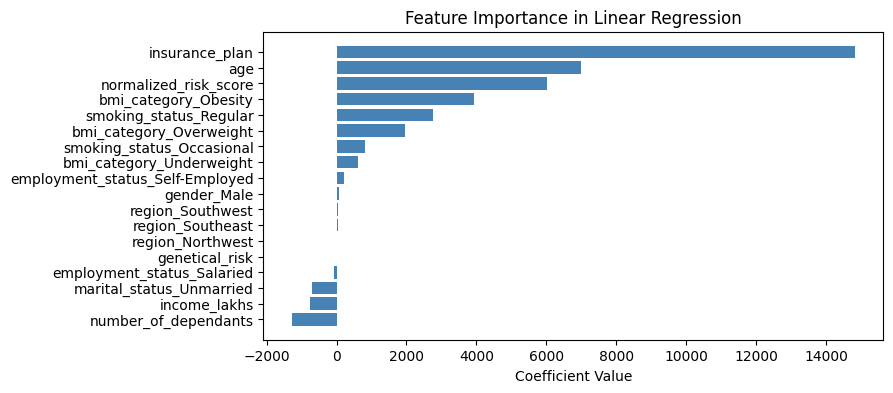

In [129]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [130]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.953525012367919, 0.9535936921301669)

In [131]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  2224550.1113919285 RMSE:  1491.492578389825


In [132]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9938390851020813

In [133]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  295330.8125 RMSE:  543.443476821647


In [134]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9969904621442159)

In [135]:
best_model = random_search.best_estimator_

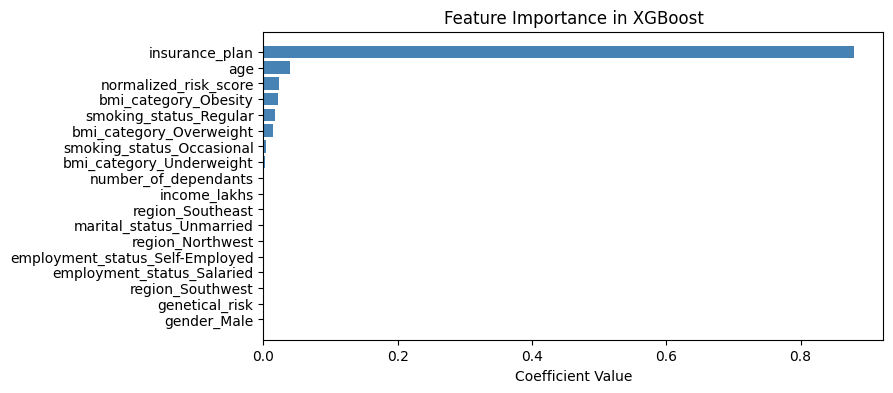

In [136]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

#### Error Analysis

In [137]:
y_pred= best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct= residuals*100/y_test

results_df = pd.DataFrame({
    "actual":y_test,
    "predicted":y_pred,
    "diff":residuals,
    "diff_pct":residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
7354,18414,17817.152344,-596.847656,-3.241271
4620,17842,17482.769531,-359.230469,-2.013398
22824,17614,17637.837891,23.837891,0.135335
15957,24896,24110.890625,-785.109375,-3.153556
29620,15686,15843.738281,157.738281,1.005599


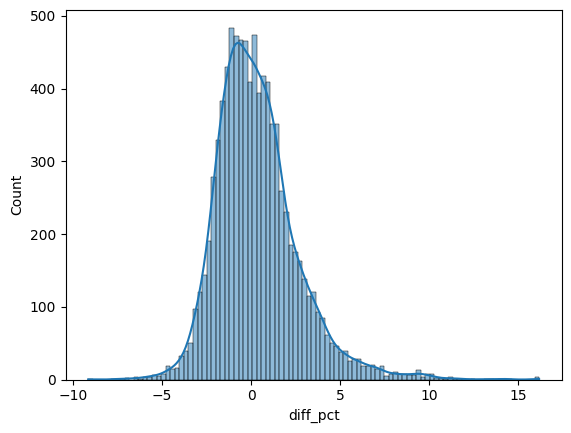

In [138]:
sns.histplot(results_df["diff_pct"],kde=True)
plt.show()

In [139]:
extreme_error_threshold=10

extreme_results_df=results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]

extreme_results_df.shape

(27, 4)

In [140]:
extreme_errors_pct=extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

0.3017771319995529

In [141]:
X_test.index

Index([ 7354,  4620, 22824, 15957, 29620, 28859, 23430, 16631,  8145,  3935,
       ...
       17201, 21387, 27097,  9142, 26307, 10556, 26442, 22554, 23975,  6104],
      dtype='int64', length=8947)

In [142]:
extreme_results_df.index

Index([12746,  4655, 13744, 20609,   252, 14843,  5588,  7547,  3979,  8270,
        7559, 19857,  6236,  2037, 26591, 26528, 21910, 29497, 24119,  5348,
       22666,  8216, 16263, 14728, 28374, 18681,  6137],
      dtype='int64')

In [143]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12746,0.065217,0.0,0.040404,0.0,0.0,0.000000,0,0,0,1,1,0,0,1,0,0,1,0
4655,0.478261,0.2,0.212121,0.0,0.0,0.857143,0,0,1,0,1,0,0,0,0,0,0,1


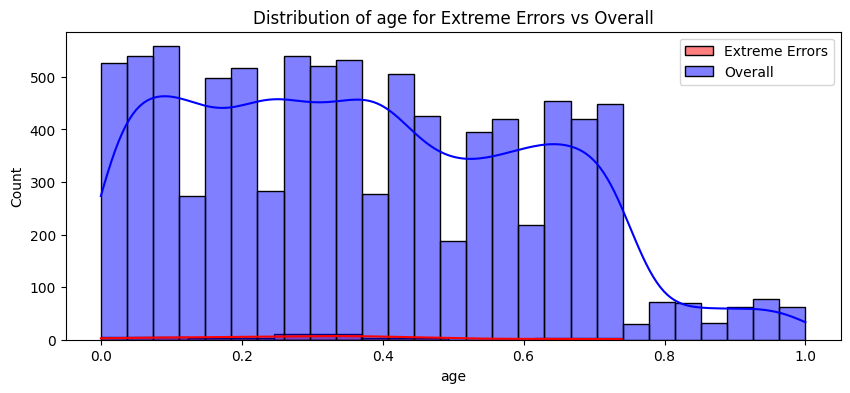

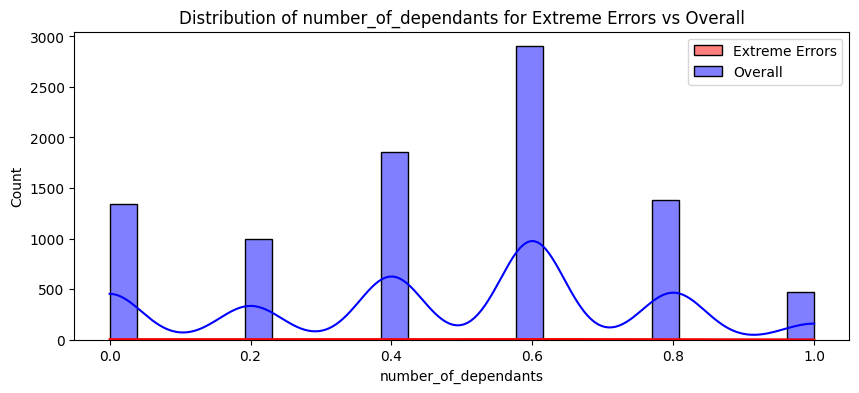

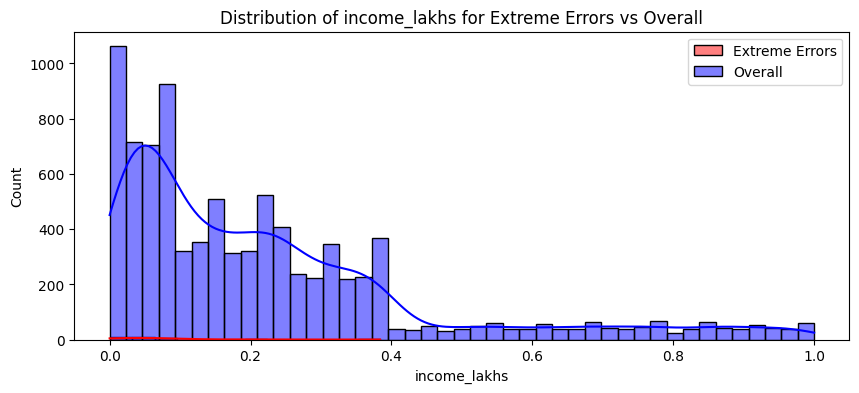

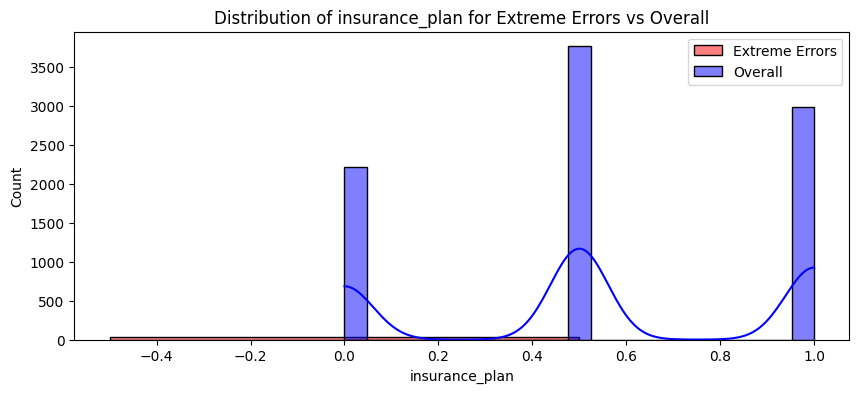

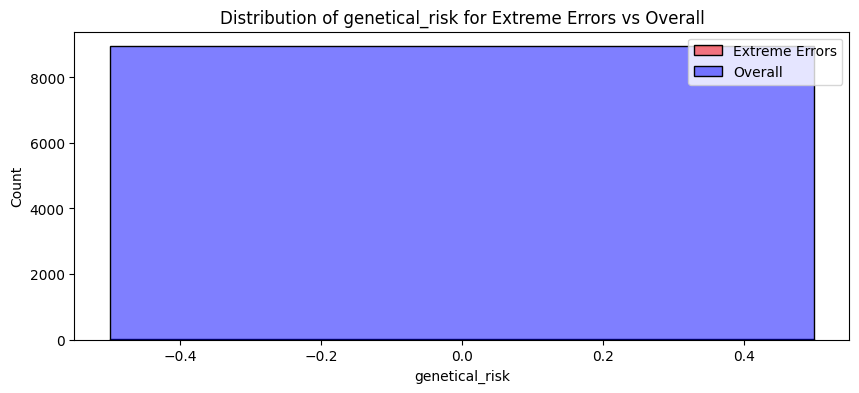

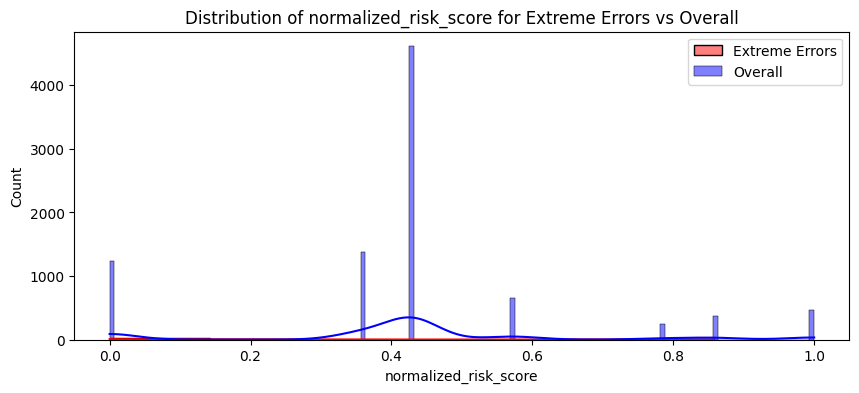

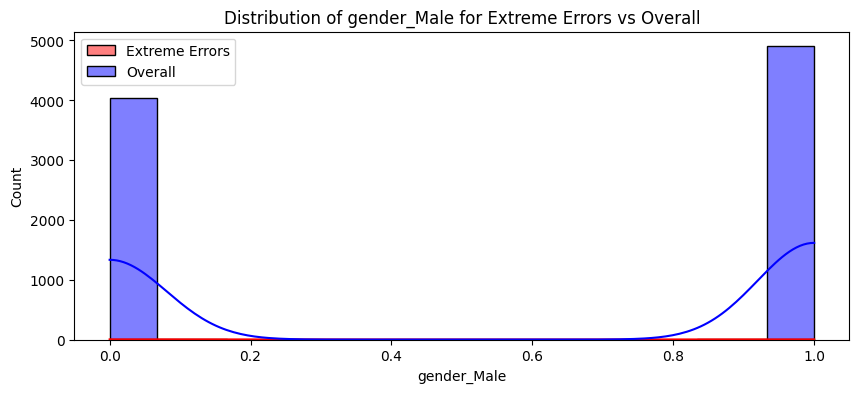

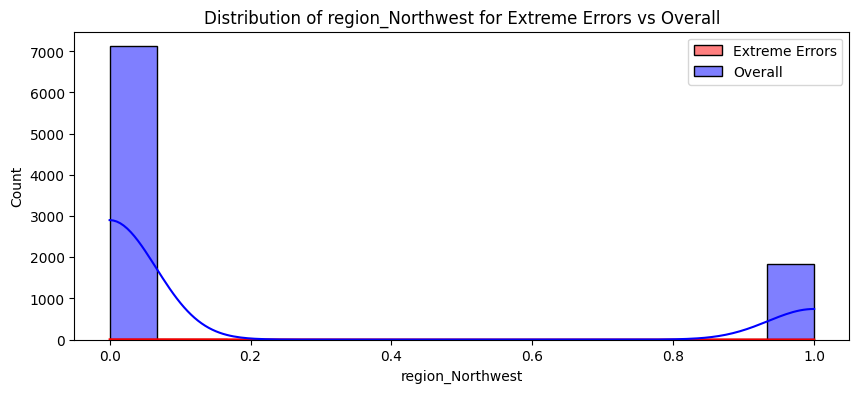

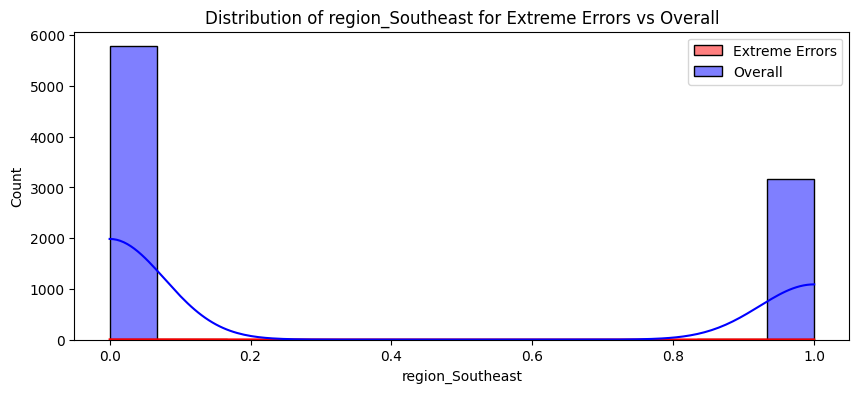

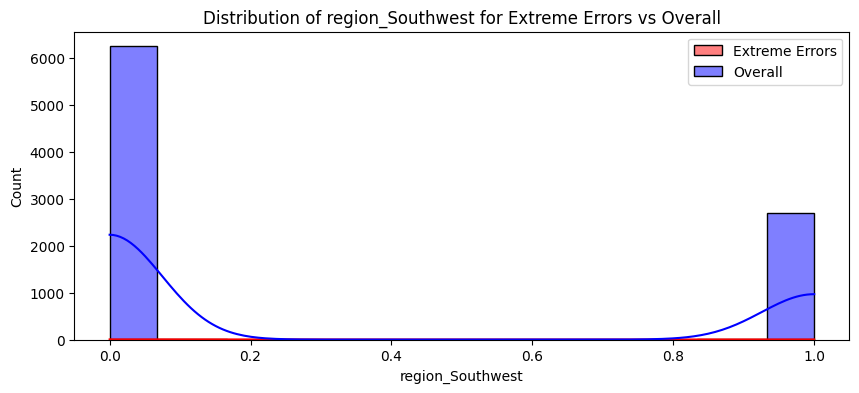

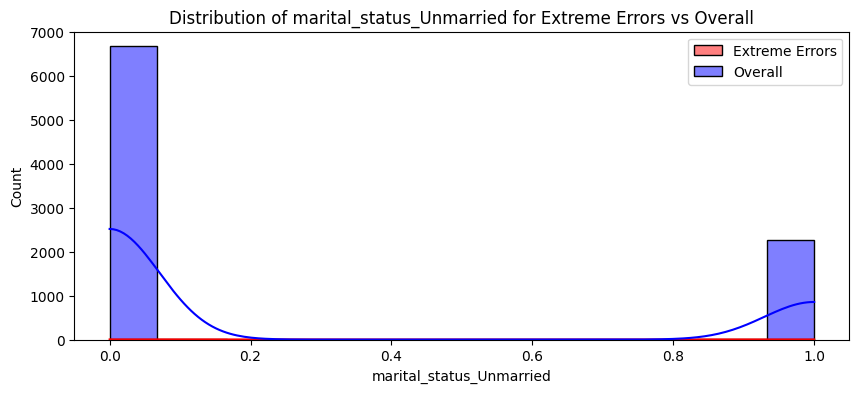

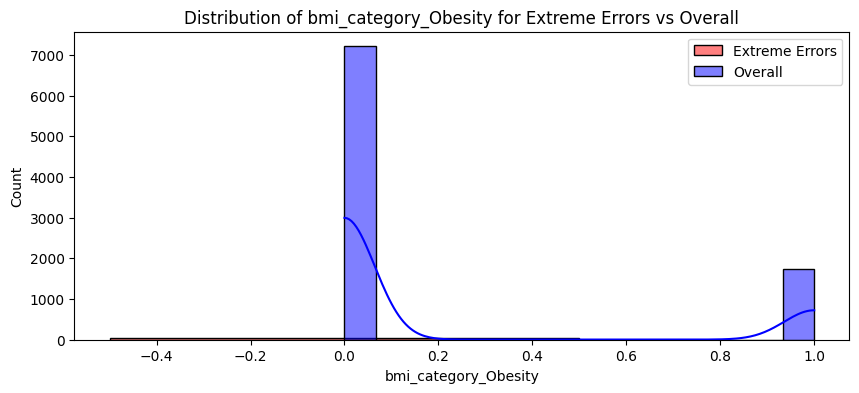

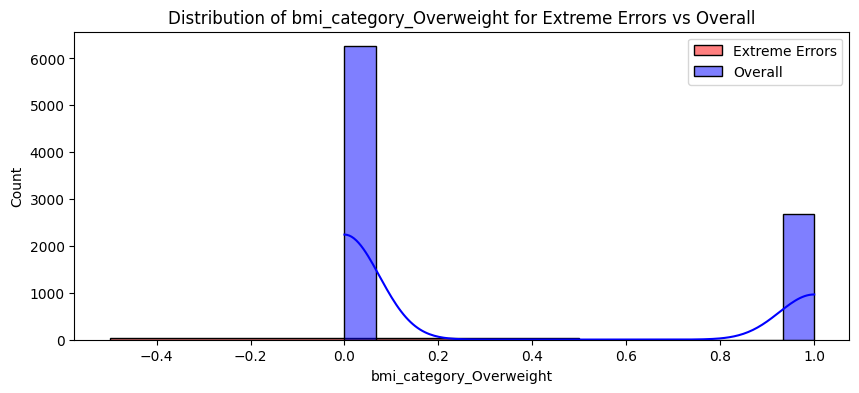

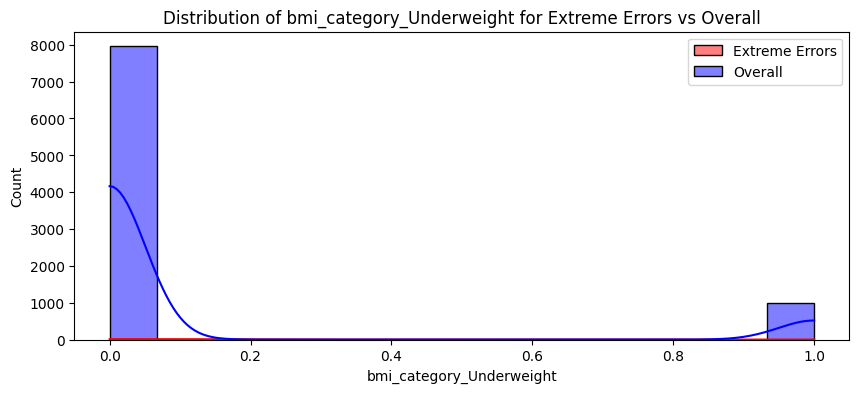

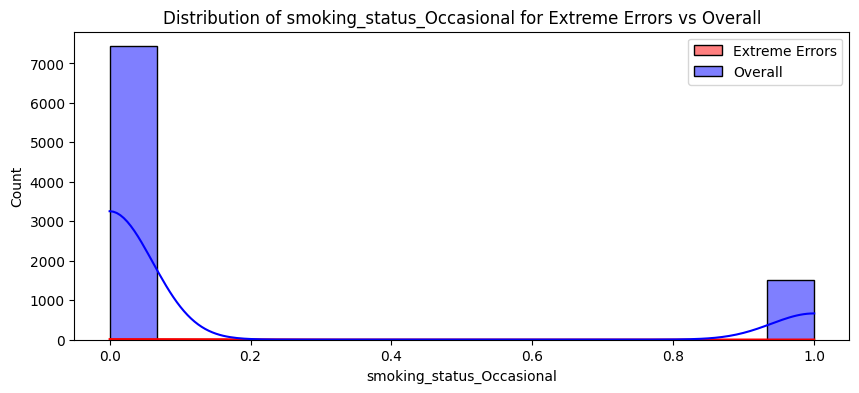

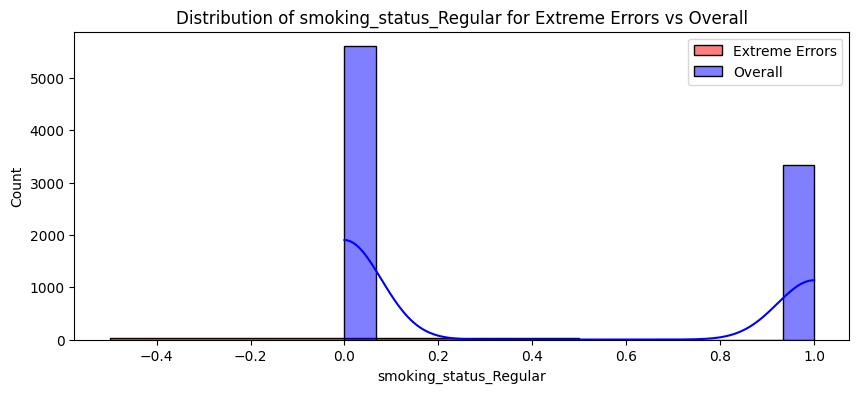

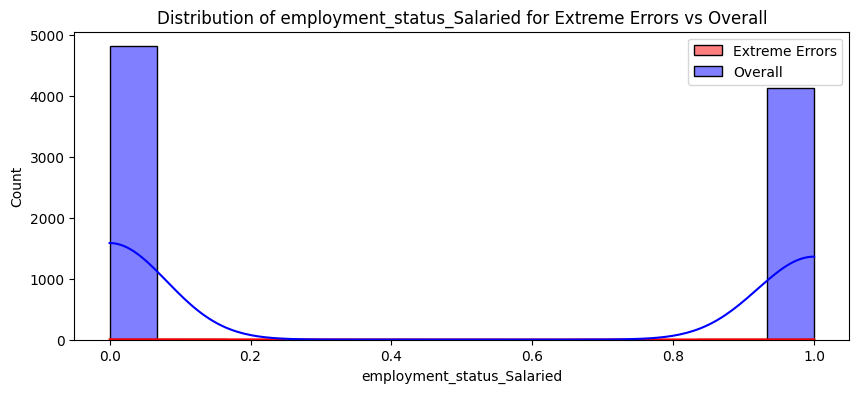

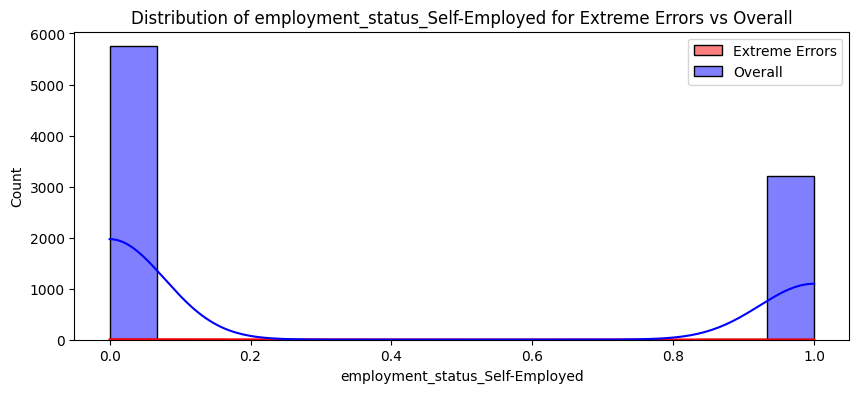

In [144]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

In [145]:
extreme_errors_df['income_level']=-1

In [146]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk
0,29.0,0.0,-2.0,5.0,1.0,0.0
1,48.0,1.0,-2.0,22.0,1.0,0.0
2,40.0,1.0,-2.0,9.0,1.0,0.0
3,30.0,4.0,-2.0,1.0,1.0,0.0
4,29.0,3.0,-2.0,3.0,1.0,0.0


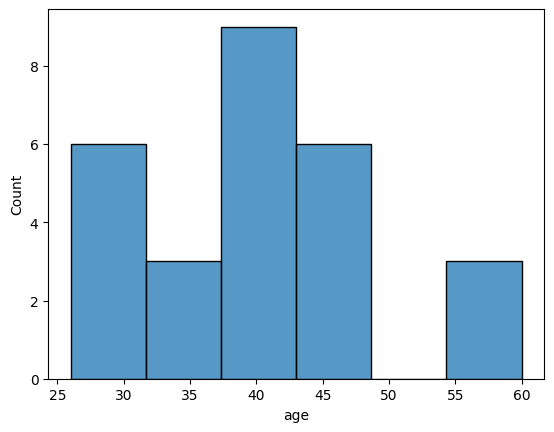

In [147]:
sns.histplot(df_reversed.age)
plt.show()

### Export Model

In [148]:
from joblib import dump

dump(best_model,"../resources/artifact/model_rest.joblib")

scaler_with_cols={
    "scaler":scaler,
    "cols_to_scale":cols_to_scale
}

dump(scaler_with_cols,"../resources/artifact/scaler_rest.joblib")

['../resources/artifact/scaler_rest.joblib']